<a href="https://colab.research.google.com/github/Vatshal-Venkat/Agent-Teaser/blob/main/TrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy python-levenshtein xgboost plotly -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.0 MB/s eta 0:00:00


Saving Trainee.xlsx to Trainee (3).xlsx


Data Loaded. Shape: (2013, 23)

Performing data validation...
Duplicates removed. New shape: (1992, 16)
 DISTRICT has low variance (1 classes, min 1992 samples). PS also low variance. Skipping ML.
Skipping ML part.



Preparing data for Frequency Prediction on PS...

Ready for predictions!
Enter the crime type (e.g., 'Robbery'): Rape
Interpreted as: Rape (match score: 100)

ML model not available.

Frequency Prediction for PS: Most likely for 'Rape' are:

1. Paderu  (Probability: 0.186)
2. Chinthapalli  (Probability: 0.093)
3. Gangaraju Madugula(G.Madugula)  (Probability: 0.070)
4. Hukumpeta  (Probability: 0.070)
5. Munchingiput  (Probability: 0.070)
6. Yetapaka  (Probability: 0.070)
7. Gangavaram  (Probability: 0.070)
8. Araku  (Probability: 0.047)
9. Donkarai  (Probability: 0.047)
10. Devipatnam  (Probability: 0.047)
Frequency predictions exported to freq_predictions.csv


/tmp/ipython-input-1373932420.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




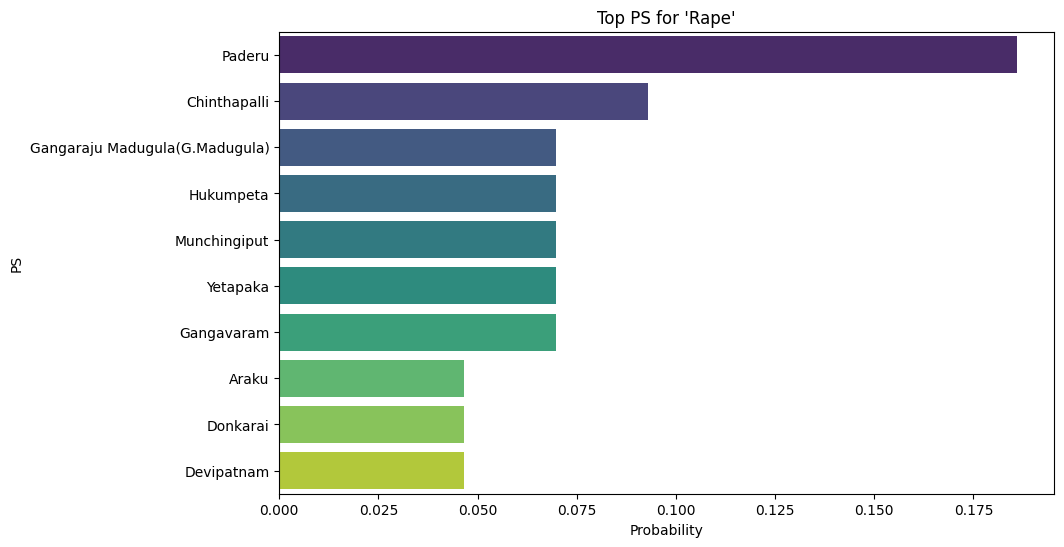


Script completed. Check crime_predictor.log for details.


In [ ]:
# ==========================================================
# 📊 Enhanced Combined Crime Predictor: District (ML) + Police Station (Frequency)
# ==========================================================
# Author: Enhanced Combined Version
# Goal:
#   1. Use ML (RandomForest + XGBoost) to predict likely DISTRICT based on engineered features.
#   2. Use frequency analysis to predict likely POLICE STATION (PS) for a given MAJOR_HEAD.
#   Added: Data validation, fuzzy matching, feature engineering, cross-val, saving/loading, interactive viz (Plotly), logging.
#   Fixed: Handle cases with 1 class or switch to PS for ML if DISTRICT has low variance.
# ==========================================================

# --- 0️⃣ Install Dependencies (Colab-friendly) ---
!pip install fuzzywuzzy python-levenshtein xgboost plotly -q

# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from fuzzywuzzy import process
import joblib
import logging
import plotly.express as px
import os

# Setup Logging
logging.basicConfig(filename='crime_predictor.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Script started.")

# --- 2️⃣ Upload Excel ---
try:
    uploaded = files.upload()    # Upload your Excel file (e.g., Trainee.xlsx or 2022_Reported.xlsx)
    file_name = list(uploaded.keys())[0]
    df = pd.read_excel(file_name)
    print("Data Loaded. Shape:", df.shape)
    logging.info(f"Data loaded: {df.shape}")
except Exception as e:
    print("Error uploading file:", e)
    logging.error(f"Upload error: {e}")
    raise

df.head()

# --- 3️⃣ Enhanced Basic Cleaning & Validation ---
drop_cols = ['FIR_NO', 'ACTS_SEC', 'ALTERATION_DT', 'CS_DATE',
             'TAKENONFILE_DATE', 'DISPOSAL_DT', 'BRIEF_FACTS']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Normalize column names
df.columns = df.columns.str.strip().str.upper()

# Handle alternative column names
district_col = 'DISTRICT' if 'DISTRICT' in df.columns else None
major_head_col = 'MAJOR_HEAD' if 'MAJOR_HEAD' in df.columns else 'CRIME TYPE'
minor_head_col = 'MINOR_HEAD' if 'MINOR_HEAD' in df.columns else None
ps_col = 'PS' if 'PS' in df.columns else 'POLICE STATION'

# Fill missing values early
df = df.fillna('Unknown')

print("\nPerforming data validation...")
required_cols = [major_head_col]  # Relaxed: ML can use PS if available
missing_cols = [col for col in required_cols if col not in df.columns or col is None]
if missing_cols:
    error_msg = f"Missing required columns: {missing_cols}. Check your Excel headers."
    print(error_msg)
    logging.error(error_msg)
    raise ValueError(error_msg)

# Remove duplicates
df = df.drop_duplicates()
print(f"Duplicates removed. New shape: {df.shape}")
logging.info(f"Duplicates removed. Shape: {df.shape}")

# Validate and clean numeric/date fields
if 'FIR_YEAR' in df.columns:
    df['FIR_YEAR'] = pd.to_numeric(df['FIR_YEAR'], errors='coerce')
    df = df[df['FIR_YEAR'].between(2000, 2030)]  # Assuming modern data
    logging.info("FIR_YEAR validated.")
if 'FIR_MONTH' in df.columns:
    df['FIR_MONTH'] = pd.to_numeric(df['FIR_MONTH'], errors='coerce')
    df['FIR_MONTH'] = df['FIR_MONTH'].clip(1, 12)  # Valid months
    logging.info("FIR_MONTH validated.")

# Handle typos in categorical fields
df[major_head_col] = df[major_head_col].str.strip().str.title()
if ps_col:
    df[ps_col] = df[ps_col].str.strip().str.title()
if district_col:
    df[district_col] = df[district_col].str.strip().str.title()

# ==========================================================
# Part 1: ML-Based Prediction (Flexible: DISTRICT or PS as target)
# ==========================================================
model = None
xgb_model = None
le_dict = {}
target_col = None

# Choose target: Prefer DISTRICT if varied, else PS
if district_col:
    class_counts = df[district_col].value_counts()
    unique_districts = len(class_counts)
    if unique_districts >= 2 and class_counts.min() >= 5:
        target_col = district_col
        print(f"Using DISTRICT as ML target ({unique_districts} classes).")
    else:
        print(f" DISTRICT has low variance ({unique_districts} classes, min {class_counts.min()} samples). ", end="")
else:
    print("No varied DISTRICT column. ", end="")

if target_col is None and ps_col:
    class_counts_ps = df[ps_col].value_counts()
    unique_ps = len(class_counts_ps)
    if unique_ps >= 2 and class_counts_ps.min() >= 3:  # Lower threshold for PS
        target_col = ps_col
        print(f"Switching to PS as ML target ({unique_ps} classes).")
    else:
        print("PS also low variance. Skipping ML.")
else:
    if target_col is None:
        print("Skipping ML.")

if target_col and major_head_col:
    print("\nPreparing data for ML Prediction...")
    logging.info(f"ML target: {target_col}")

    # Keep only important fields for ML part
    keep_cols_ml = [target_col, major_head_col, minor_head_col, 'FIR_MONTH', 'FIR_YEAR',
                    'CASE_STAGE', 'TYPE_OF_DISP', 'GRAVE', 'OCCURENCE_PLACE']
    keep_cols_ml = [c for c in keep_cols_ml if c in df.columns]
    df_ml = df[keep_cols_ml].copy()

    # Remove rows missing target or major crime type
    df_ml = df_ml.dropna(subset=[target_col, major_head_col])

    # --- Handle small/rare classes ---
    min_samples_per_class = 5 if target_col == district_col else 3
    class_counts = df_ml[target_col].value_counts()
    valid_classes = class_counts[class_counts >= min_samples_per_class].index
    df_ml = df_ml[df_ml[target_col].isin(valid_classes)]
    print(f"Filtered to {len(valid_classes)} {target_col} with >= {min_samples_per_class} samples. New ML shape: {df_ml.shape}")

    if len(valid_classes) < 2:
        print(f"Not enough classes for ML on {target_col}. Skipping ML training.")
        model = None
    else:
        # --- Feature Engineering ---
        season_map = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer',
                      7:'Summer', 8:'Summer', 9:'Monsoon', 10:'Monsoon', 11:'Monsoon', 12:'Winter'}
        if 'FIR_MONTH' in df_ml.columns:
            df_ml['SEASON'] = df_ml['FIR_MONTH'].map(season_map)
            print("Added SEASON feature.")

        if major_head_col in df_ml.columns and 'GRAVE' in df_ml.columns:
            df_ml['CRIME_GRAVE_INTERACT'] = df_ml[major_head_col].astype(str) + '_' + df_ml['GRAVE'].astype(str)
            print("Added CRIME_GRAVE_INTERACT feature.")

        # --- Encode Categorical Features ---
        cat_cols = df_ml.select_dtypes(include='object').columns
        for col in cat_cols:
            le = LabelEncoder()
            df_ml[col] = le.fit_transform(df_ml[col].astype(str))
            le_dict[col] = le

        # --- Split Feature and Target ---
        X = df_ml.drop(target_col, axis=1)
        y = df_ml[target_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # --- Train RandomForest Model ---
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=14,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        # --- Train XGBoost Model ---
        num_classes = len(np.unique(y))
        try:
            xgb_model = XGBClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42,
                n_jobs=-1,
                objective='multi:softprob',
                num_class=num_classes,
                eval_metric='mlogloss',
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8
            )
            xgb_model.fit(X_train, y_train)
            print("XGBoost trained successfully.")
        except Exception as xgb_e:
            print("XGBoost training failed:", xgb_e)
            logging.error(f"XGBoost error: {xgb_e}")
            xgb_model = None

        # --- Evaluate RF ---
        y_pred = model.predict(X_test)
        print(f"\nRandomForest Accuracy on {target_col}: {round(accuracy_score(y_test, y_pred)*100, 2)}%")

        # --- Evaluate XGBoost ---
        if xgb_model:
            xgb_pred = xgb_model.predict(X_test)
            print(f"XGBoost Accuracy on {target_col}: {round(accuracy_score(y_test, xgb_pred)*100, 2)}%")

        # --- Cross-Validation (RF) ---
        scores = cross_val_score(model, X, y, cv=min(5, len(y)//5))
        print(f"CV Scores (RF): {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

        # --- Visualization of Feature Importance (RF) ---
        feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        plt.figure(figsize=(8,6))
        sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
        plt.title(f"Top Features Influencing {target_col} Prediction (RF)")
        plt.show()

        # --- Confusion Matrix ---
        unique_labels = np.unique(y_test)
        cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
        disp_labels = [le_dict[target_col].inverse_transform([label])[0] for label in unique_labels[:10]]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[:10, :10], display_labels=disp_labels)
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix for {target_col} Prediction (Top Classes)")
        plt.show()

        # --- Save Model and Encoders ---
        joblib.dump(model, f'{target_col.lower()}_model_rf.pkl')
        if xgb_model:
            joblib.dump(xgb_model, f'{target_col.lower()}_model_xgb.pkl')
        joblib.dump(le_dict, 'le_dict.pkl')
        print("Models and encoders saved.")
        logging.info("ML models trained and saved.")
else:
    print("Skipping ML part.")
    logging.warning("ML part skipped.")

# --- Additional Visualizations: Crime Hierarchy Treemap (use available location) ---
location_col = district_col if district_col else ps_col
if location_col and major_head_col:
    crime_pivot = df.groupby([location_col, major_head_col]).size().reset_index(name='Count')
    fig = px.treemap(crime_pivot, path=[location_col, major_head_col], values='Count', title=f'Crime Hierarchy by {location_col} and Type')
    fig.show()
    logging.info("Treemap visualization shown.")

# ==========================================================
# Part 2: Frequency-Based Police Station Prediction (or District if no PS)
# ==========================================================
freq_target_col = ps_col if ps_col else district_col
if freq_target_col and major_head_col:
    print(f"\nPreparing data for Frequency Prediction on {freq_target_col}...")
    df_freq = df.dropna(subset=[freq_target_col, major_head_col])
    logging.info(f"Frequency target: {freq_target_col}")
else:
    print("Required columns for frequency prediction not found. Skipping.")
    df_freq = pd.DataFrame()
    logging.warning("Frequency part skipped.")

# --- Combined User Query with Fuzzy Matching ---
print("\nReady for predictions!")
user_input = input("Enter the crime type (e.g., 'Robbery'): ").strip().lower()

# Fuzzy matching for crime type
all_crimes_raw = le_dict.get(major_head_col, {}).classes_ if model else df[major_head_col].unique()
all_crimes = [str(c).lower() for c in all_crimes_raw]

if all_crimes:
    best_match, score = process.extractOne(user_input, all_crimes)
    if score > 70:
        user_input = best_match
        print(f"Interpreted as: {best_match.title()} (match score: {score})")
        logging.info(f"Fuzzy match: {user_input} (score: {score})")
    else:
        print("No close match found. Proceeding with exact input.")
        logging.warning("No fuzzy match found.")

try:
    # --- Predict with ML (if available) ---
    if model and major_head_col in le_dict:
        all_crimes_le = [c.lower() for c in le_dict[major_head_col].classes_]
        if user_input in all_crimes_le:
            match_idx = all_crimes_le.index(user_input)
            match = le_dict[major_head_col].classes_[match_idx]
            encoded_crime = le_dict[major_head_col].transform([match])[0]

            # Create sample
            sample_data = {}
            for col in X.columns:
                mode_val = df_ml[col].mode()[0] if col in df_ml.columns else 0
                sample_data[col] = [mode_val]
            sample = pd.DataFrame(sample_data)
            sample[major_head_col] = encoded_crime

            # Handle engineered
            if 'SEASON' in X.columns and 'SEASON' in le_dict:
                season_str = season_map.get(sample['FIR_MONTH'][0], 'Unknown')
                sample['SEASON'] = le_dict['SEASON'].transform([season_str])[0] if season_str in le_dict['SEASON'].classes_ else 0
            if 'CRIME_GRAVE_INTERACT' in X.columns and 'CRIME_GRAVE_INTERACT' in le_dict:
                interact_str = f"{match}_{sample['GRAVE'][0]}"
                sample['CRIME_GRAVE_INTERACT'] = le_dict['CRIME_GRAVE_INTERACT'].transform([interact_str])[0] if interact_str in le_dict['CRIME_GRAVE_INTERACT'].classes_ else 0

            # Predict RF
            probs = model.predict_proba(sample)[0]
            top_idx = np.argsort(probs)[::-1][:5]
            top_locations = le_dict[target_col].inverse_transform(top_idx)

            print(f"\nML Prediction (RF) for {target_col}: Most likely for '{match}' are:\n")
            for i, loc in enumerate(top_locations, 1):
                print(f"{i}. {loc}  (Probability: {probs[top_idx[i-1]]:.3f})")

            if xgb_model:
                xgb_probs = xgb_model.predict_proba(sample)[0]
                xgb_top_idx = np.argsort(xgb_probs)[::-1][:5]
                xgb_top_locations = le_dict[target_col].inverse_transform(xgb_top_idx)
                print(f"\nML Prediction (XGBoost) for {target_col}: Most likely for '{match}' are:\n")
                for i, loc in enumerate(xgb_top_locations, 1):
                    print(f"{i}. {loc}  (Probability: {xgb_probs[xgb_top_idx[i-1]]:.3f})")
        else:
            print("\nCrime type not found for ML prediction.")
    else:
        print("\nML model not available.")

    # --- Frequency Prediction ---
    filtered = df_freq[df_freq[major_head_col].str.lower().str.contains(user_input, na=False)]
    if filtered.empty:
        print(f"\nNo records found for '{user_input.title()}' in frequency analysis.")
    else:
        freq_counts = filtered[freq_target_col].value_counts(normalize=True).head(10)

        print(f"\nFrequency Prediction for {freq_target_col}: Most likely for '{user_input.title()}' are:\n")
        for i, (loc, prob) in enumerate(freq_counts.items(), start=1):
            print(f"{i}. {loc}  (Probability: {prob:.3f})")

        # Export
        freq_counts.to_csv('freq_predictions.csv')
        print("Frequency predictions exported to freq_predictions.csv")

        # Viz
        plt.figure(figsize=(10,6))
        sns.barplot(x=freq_counts.values, y=freq_counts.index, palette="viridis")
        plt.xlabel("Probability")
        plt.ylabel(freq_target_col)
        plt.title(f"Top {freq_target_col} for '{user_input.title()}'")
        plt.show()

        fig_ps = px.bar(freq_counts.reset_index(), x='proportion', y=freq_target_col, orientation='h',
                        title=f"Top {freq_target_col} for {user_input.title()}", labels={'proportion': 'Probability'})
        fig_ps.show()

    logging.info("Predictions completed.")

except Exception as e:
    print("An error occurred during prediction:", e)
    logging.error(f"Prediction failed: {e}")

print("\nScript completed. Check crime_predictor.log for details.")

Saving Trainee.xlsx to Trainee (2).xlsx
✅ Data Loaded. Shape: (2013, 23)

🛠️ Preparing data for District Prediction (ML Model)...

✅ ML Model Accuracy: 100.0 %


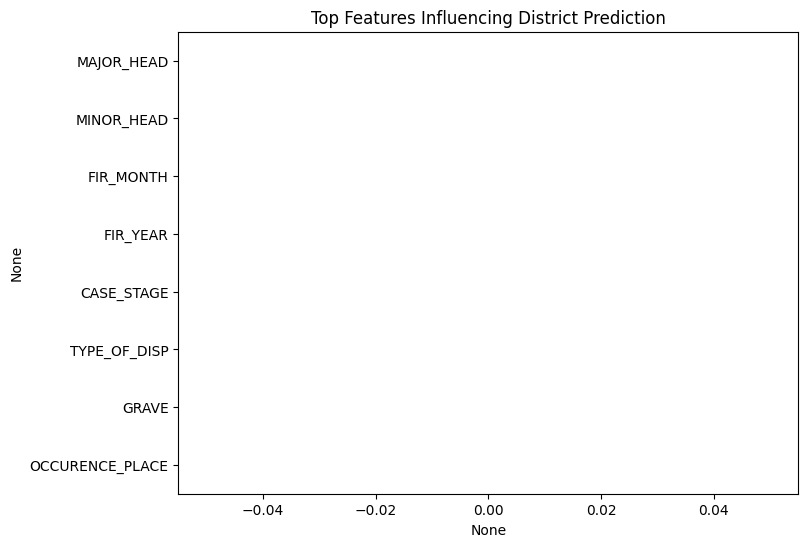


🛠️ Preparing data for Police Station Prediction (Frequency Analysis)...

🔮 Ready for predictions!
Enter the crime type (e.g., 'Robbery'): Fatal Road Accident

🔮 ML Prediction: Most likely districts for 'Fatal Road Accidents' are:

1. Alluri Sitharama Raju  (Probability: 1.000)

🔮 Frequency Prediction: Most likely police stations for 'Fatal Road Accident' are:

1. Chintoor  (Probability: 0.152)
2. Paderu  (Probability: 0.122)
3. Rampachodavaram  (Probability: 0.114)
4. Araku  (Probability: 0.065)
5. Anantagiri  (Probability: 0.057)
6. Gudemkothaveedi (G.K.Veedhi)  (Probability: 0.053)
7. Maredumilli  (Probability: 0.049)
8. Dumbriguda  (Probability: 0.034)
9. Addateegala  (Probability: 0.034)
10. Moothugudem  (Probability: 0.034)


/tmp/ipython-input-4041751929.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ps_counts.values, y=ps_counts.index, palette="viridis")


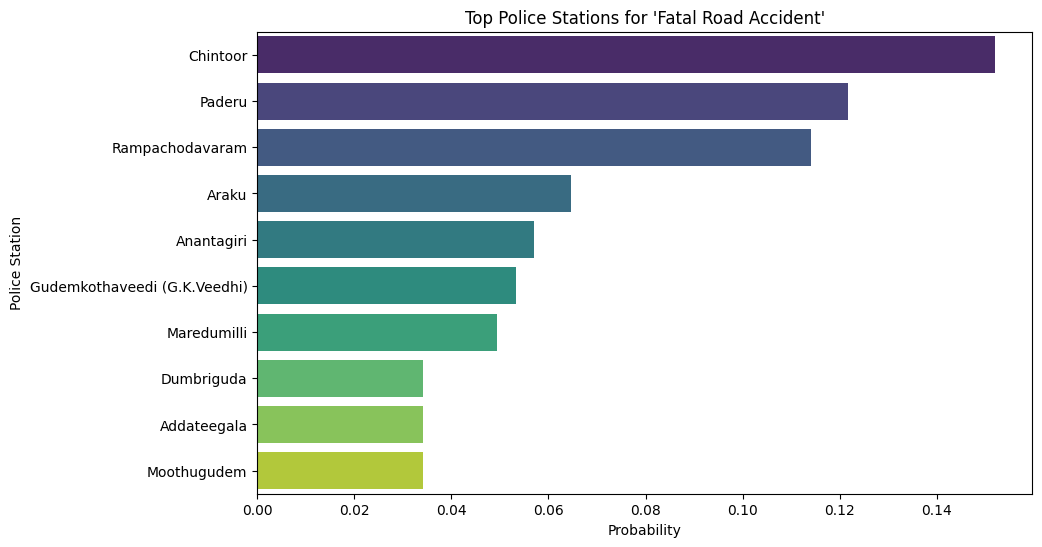

In [ ]:
# ==========================================================
# 📊 Combined Crime Predictor: District (ML) + Police Station (Frequency)
# ==========================================================
# Author: Combined Version
# Goal:
#   1. Use ML (RandomForest) to predict likely DISTRICT based on crime features.
#   2. Use frequency analysis to predict likely POLICE STATION (PS) for a given MAJOR_HEAD.
# ==========================================================

# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# --- 2️⃣ Upload Excel ---
uploaded = files.upload()    # Upload your Excel file (e.g., Trainee.xlsx or 2022_Reported.xlsx)
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)
print("✅ Data Loaded. Shape:", df.shape)
df.head()

# --- 3️⃣ Basic Cleaning (Common to Both) ---
drop_cols = ['FIR_NO', 'ACTS_SEC', 'ALTERATION_DT', 'CS_DATE',
             'TAKENONFILE_DATE', 'DISPOSAL_DT', 'BRIEF_FACTS']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Normalize column names
df.columns = df.columns.str.strip().str.upper()

# Handle alternative column names
district_col = 'DISTRICT' if 'DISTRICT' in df.columns else None
major_head_col = 'MAJOR_HEAD' if 'MAJOR_HEAD' in df.columns else 'CRIME TYPE'
minor_head_col = 'MINOR_HEAD' if 'MINOR_HEAD' in df.columns else None
ps_col = 'PS' if 'PS' in df.columns else 'POLICE STATION'

# Fill missing values early
df = df.fillna('Unknown')

# ==========================================================
# Part 1: ML-Based District Prediction
# ==========================================================
if district_col and major_head_col:
    print("\n🛠️ Preparing data for District Prediction (ML Model)...")

    # Keep only important fields for ML part
    keep_cols_ml = [district_col, major_head_col, minor_head_col, 'FIR_MONTH', 'FIR_YEAR',
                    'CASE_STAGE', 'TYPE_OF_DISP', 'GRAVE', 'OCCURENCE_PLACE']
    keep_cols_ml = [c for c in keep_cols_ml if c in df.columns]
    df_ml = df[keep_cols_ml].copy()

    # Remove rows missing district or major crime type
    df_ml = df_ml.dropna(subset=[district_col, major_head_col])

    # --- Encode Categorical Features ---
    le_dict = {}
    cat_cols = df_ml.select_dtypes(include='object').columns
    for col in cat_cols:
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col].astype(str))
        le_dict[col] = le

    # --- Split Feature and Target ---
    X = df_ml.drop(district_col, axis=1)
    y = df_ml[district_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # --- Train Model ---
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=14,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # --- Evaluate ---
    y_pred = model.predict(X_test)
    print("\n✅ ML Model Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
    # print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Uncomment if needed

    # --- Visualization of Feature Importance ---
    feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
    plt.title("Top Features Influencing District Prediction")
    plt.show()
else:
    print("⚠️ Required columns for ML District prediction not found. Skipping ML part.")
    model = None
    le_dict = {}

# ==========================================================
# Part 2: Frequency-Based Police Station Prediction
# ==========================================================
if ps_col and major_head_col:
    print("\n🛠️ Preparing data for Police Station Prediction (Frequency Analysis)...")

    # Remove rows missing PS or MAJOR_HEAD for frequency part
    df_ps = df.dropna(subset=[ps_col, major_head_col])
else:
    print("⚠️ Required columns for PS frequency prediction not found. Skipping frequency part.")
    df_ps = pd.DataFrame()

# --- Combined User Query ---
print("\n🔮 Ready for predictions!")
user_input = input("Enter the crime type (e.g., 'Robbery'): ").strip().lower()

# --- Predict District (ML) ---
if model and 'MAJOR_HEAD' in le_dict:
    all_crimes = le_dict[major_head_col].classes_
    match = [c for c in all_crimes if user_input in c.lower()]
    if len(match) == 0:
        print("\n❌ Crime type not found in dataset for ML prediction. Try checking spelling or another category.")
    else:
        encoded_crime = le_dict[major_head_col].transform([match[0]])[0]

        # Create a sample input with mode values for other columns
        sample_cols = X.columns
        sample = pd.DataFrame({col: [df_ml[col].mode()[0] if col in df_ml else 0] for col in sample_cols})
        sample[major_head_col] = encoded_crime

        # Predict probabilities
        probs = model.predict_proba(sample)[0]
        top_idx = np.argsort(probs)[::-1][:5]  # Top 5 districts
        top_districts_encoded = top_idx
        top_districts = le_dict[district_col].inverse_transform(top_districts_encoded)

        print(f"\n🔮 ML Prediction: Most likely districts for '{match[0]}' are:\n")
        for i, d in enumerate(top_districts, 1):
            print(f"{i}. {d}  (Probability: {probs[top_idx[i-1]]:.3f})")
else:
    print("\n⚠️ ML model not available for district prediction.")

# --- Predict Police Station (Frequency) ---
filtered = df_ps[df_ps[major_head_col].str.lower().str.contains(user_input, na=False)]
if filtered.empty:
    print(f"\n❌ No records found for '{user_input.title()}' in Police Station frequency analysis.")
else:
    # Count Police Stations
    ps_counts = filtered[ps_col].value_counts(normalize=True).head(10)

    # Display Results
    print(f"\n🔮 Frequency Prediction: Most likely police stations for '{user_input.title()}' are:\n")
    for i, (station, prob) in enumerate(ps_counts.items(), start=1):
        print(f"{i}. {station}  (Probability: {prob:.3f})")

    # Optional Visualization
    try:
        plt.figure(figsize=(10,6))
        sns.barplot(x=ps_counts.values, y=ps_counts.index, palette="viridis")
        plt.xlabel("Probability")
        plt.ylabel("Police Station")
        plt.title(f"Top Police Stations for '{user_input.title()}'")
        plt.show()
    except:
        print("\n⚠️ Matplotlib/Seaborn not available for visualization.")